## Visualize OTFs

This notebook is used to visualize, explore and troubleshoot OTFs that were generated from the ```radialft``` utility. 

The input is a $no$ by $nr$ by $nz$ image which contains a radially averaged 3D OTF as a $nr$ by $nz$ 2D image for each order.

In [1]:
import mrc as Mrc
from scipy.fftpack import fftn, fftshift
import numpy as np
from tnia.plotting.projections import show_xyz_slice
from tnia.plotting.projections import show_xyz_slice_center 
import matplotlib.pyplot as plt
import os

## Define OTF Name and load the MRC file

In [2]:
#otf_name = r'D:\Janelia\Data 2024-06-12\561nm OTF used\560 201909_19-20_best.mrc'
#otf_name = r'C:\Users\bnort\work\Janelia\ims\computed_OTF_folder\488nmLinOTF0.mrc'
#otf_name = r'C:\Users\bnort\work\Janelia\code\simrecon\test_data\otf.dv'
otf_name = r'D:\Janelia\Data For Brian\Cryo-SIM Scope #2 Data (James System)\PSFs (best PSFs and examples of bad ones)\BEAD 2 - NON-AR 1.2W 25ms retake_20240503_170242 GOOD PSF!!\computed_OTF_folder\488nmLinOTF0.mrc'
#otf_name = r'D:\Janelia\Data For Brian\Cryo-SIM Scope #1 Data (Ground truth baseline)\Ground truth OTFs System #1\488 OTF Bead 8_20190919_141256.mrc'
#otf_name = r'C:\Users\bnort\work\Janelia\ims\cropped_MRC\from_debugger.mrc'
#otf_name = r'D:\Janelia\Data 2024-06-03\PSF-OTF used (Davids set of 4 wavelengths)\201909_19-20_best\488 OTF Bead 8_20190919_141256.mrc'

otf_mrc = Mrc.Mrc(otf_name)
otf_data = otf_mrc.data
print(otf_data.shape, otf_data.dtype)
otf_mrc
sxy, sxy, sz = otf_mrc.header.d[0], otf_mrc.header.d[1], otf_mrc.header.d[2]
print(sxy, sxy, sz)

(3, 81, 65) >c8
0.048076924 0.048076924 0.0


## Visualize OTF and PSF

For each order visualize both the OTF and PSF.  

1.  Perform an inverse real FFT so we can display and troubleshoot the PSF 

2.  take the transpose of the PSF then perform a complex FFT so that we can get look at the FFT in the same format as displayed in Gustafsson/Shao et. al 2008 page 4961.
 

(65, 160)


C:\Users\bnort\AppData\Local\Temp\ipykernel_20896\592737391.py:16: RuntimeWarning: divide by zero encountered in log
  otfs_log = [np.log(otfs_abs[i]) for i in range(otf_data.shape[0])]


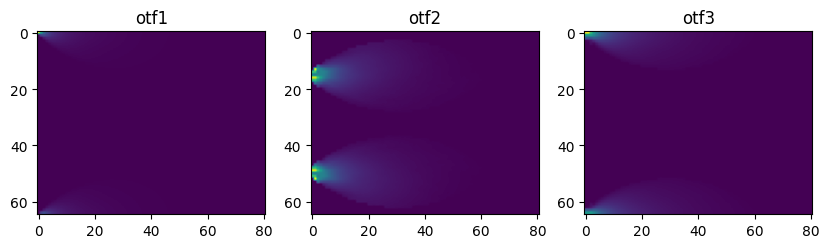

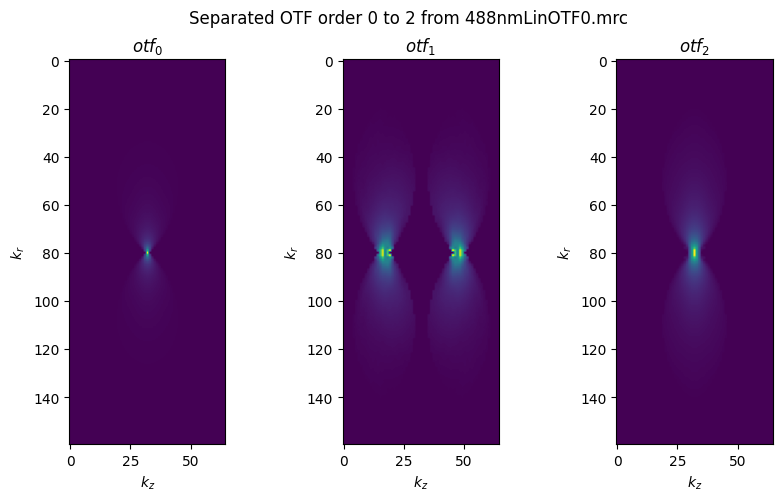

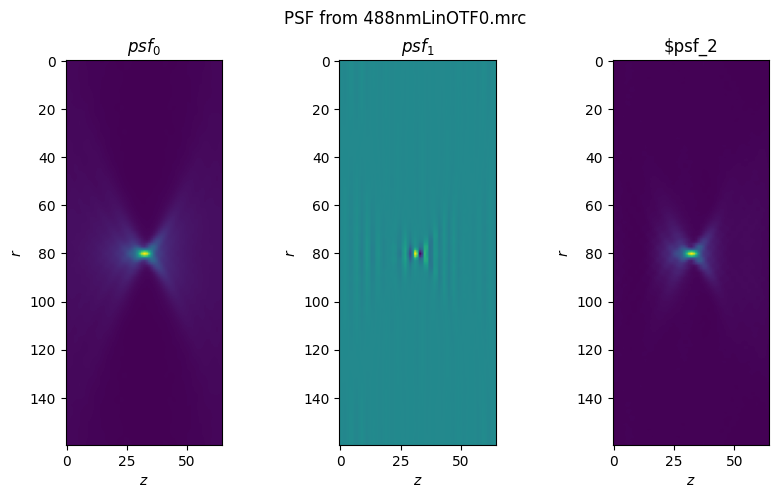

In [3]:
from tnia.plotting.plt_helper import imshow_multi2d
otf = [np.transpose(otf_data[i,:,:] ) for i in range(otf_data.shape[0])]
otf_abs = [np.abs(otf[i]) for i in range(otf_data.shape[0])]
fig = imshow_multi2d(otf_abs, ['otf1', 'otf2', 'otf3'], 1 ,3)

real_shape = ( otf[0].shape[0], (otf[0].shape[1]-1)*2)
print(real_shape) 

psfs = [np.fft.irfftn(o, s=real_shape) for o in otf]
psfs_list = psfs
psfs = [np.transpose(psf) for psf in psfs]
otfs = [np.fft.fftn(psf) for psf in psfs]
otfs_abs = [np.abs(fftshift(otfs[i])) for i in range(otf_data.shape[0])]
delta = 0
for o in otfs_abs: o[o<delta] = delta 
otfs_log = [np.log(otfs_abs[i]) for i in range(otf_data.shape[0])]
psfs_shift = [fftshift(psf) for psf in psfs]
fig = imshow_multi2d(otfs_abs, [f'$otf_0$', f'$otf_1$', f'$otf_2$'], 1 ,3, xlabels = [f'$k_z$', '$k_z$', '$k_z$'], ylabels = [f'$k_r$', '$k_r$', '$k_r$'], height = 5)
fig.suptitle('Separated OTF order 0 to 2 from '+os.path.basename(otf_name))
fig.savefig(r'D:\Janelia\Data 2024-06-12\band_figures\separated_otfs.png')
fig = imshow_multi2d(psfs_shift, ['$psf_0$', '$psf_1$', '$psf_2'], 1 ,3, xlabels = [f'$z$', '$z$', '$z$'], ylabels = [f'$r$', '$r$', '$r$'], height = 5)
fig.suptitle('PSF from '+os.path.basename(otf_name))
fig.savefig(r'D:\Janelia\Data 2024-06-12\band_figures\separated_psfs.png')

#otf_ = [np.fft.fftn(psf) for psf in psfs]
#fig = imshow_multi2d([np.abs(otf_[i]) for i in range(otf.shape[0])], ['otf1', 'otf2', 'otf3'], 1 ,3)

## Visualize OTFs in Napari

In [7]:
import napari
viewer = napari.Viewer()
viewer.add_image(np.abs(otf_data[0,:,:]))
viewer.add_image(np.abs(otf_data[1,:,:]))
viewer.add_image(np.abs(otf_data[2,:,:]))

<Image layer 'Image [2]' at 0x163b170d430>

## Draw line profile through center of second order PSF

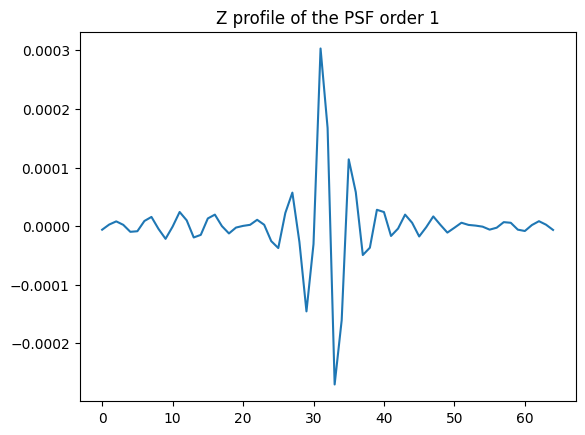

In [5]:
array = psfs_shift[1]

# Find the index of the maximum value in the flattened array
max_index_flat = np.argmax(array)

# Convert the flat index to a tuple of indices
max_index = np.unravel_index(max_index_flat, array.shape)

z_profile = array[max_index[0], :]

plt.plot(z_profile)
plt.title('Z profile of the PSF order 1')
plt.savefig(r'D:\Janelia\Data 2024-06-12\band_figures\z_profile_psf_order_1.png')


## Draw line profiles of all three orders

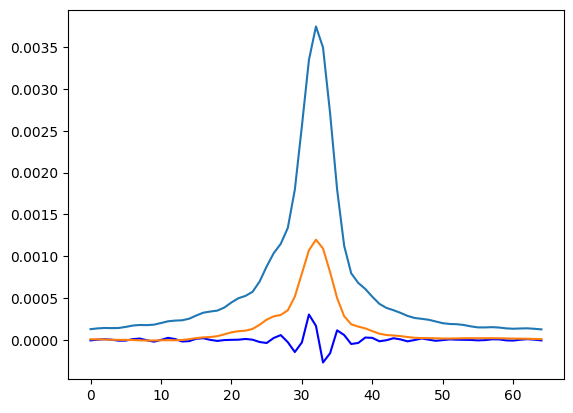

In [6]:

fig, ax = plt.subplots()
x = np.arange(0, psfs[0].shape[1])
y = psfs_shift[0][psfs[0].shape[0]//2,:]
ax.plot(x, y, label='order 1')
y = psfs_shift[1][psfs[1].shape[0]//2,:]
ax.plot(x, y, label='order 2', color='blue')
y = psfs_shift[2][psfs[2].shape[0]//2,:]
ax.plot(x, y, label='order 3')

## Visualize PSFs in Napari

In [13]:
import napari
viewer = napari.Viewer()
viewer.add_image(psfs[0], name='order 1')
viewer.add_image(psfs[1], name='order 2')
viewer.add_image(psfs[2], name='order 3')

<Image layer 'order 3' at 0x1f7f2a321f0>

## Check sum of each PSF

This is done to understand the energy in each PSF

In [10]:
for psf in psfs:
    print('Psf sum', psf.sum())

for psf in psfs:
    print('PSF abs sum',np.abs(psf).sum())

Psf sum 1.0
Psf sum 2.168404344971009e-19
Psf sum 0.10571935772895814
PSF abs sum 1.0003394974869355
PSF abs sum 0.04275282096664851
PSF abs sum 0.12507372924945268


In [15]:
from skimage.io import imsave
psf_name = r'D:\Janelia\Data 2024-06-12\561nm OTF used\560 201909_19-20_best_psf.tif'

In [23]:
imsave(psf_name, psf)

c:\Users\bnort\miniconda3\envs\simrecon_python_373\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:\Janelia\Data 2024-06-12\561nm OTF used\560 201909_19-20_best_psf.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [16]:
for psf in psfs_shift:
    print(psf.min(), psf.max(), psf.sum())

-5.83001946940908e-06 0.0035583743167010725 1.0
-0.0008576229355919798 0.0006462752785049967 6.505213034913027e-19
-3.174347996488636e-06 0.0003416930612239902 0.04312517121434212
